# Basics of Computer Vision with PyTorch

The main library for computer vision with PyTorch is `torchvision`, also important are `torchvision.datasets` where you can get datasets and data loading functions for computer vision, `torchvision.models` where you can find pre-trained computer vision models that you can leverage for your own problems, and `torchvision.transforms` that provide functions for manipulating vision data (images) in order to make them suitable for usage with an ML model.

Other important libraries are `torch.utils.data.Dataset` which is the base dataset class for PyTorch, and `torch.utils.data.DataLoader` that creates a Python iterable over a dataset .


## Setup


### Importing libraries and dataset


In [1]:
# Importing libraries
from typing import Dict, List, Any

import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from helper_functions.helper_functions import accuracy_fn

### Setting device


In [2]:
# Using gpu if available
device = 'mps' if torch.mps.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: mps


#### Importing the data

To import the _Fashion MNIST_ data from PyTorch, you can simply use `datasets.FashionMNIST`. This works much like other datasets, as parameters, this class takes `root` that specifies where the image of the dataset exists, whether you want a training dataset can be specified with `train`, `download` to download the data from the internet and put it into the `root` specified path, `transform` that takes a PIL image and returns it transformed, and `target_transform` that also takes a function to perform some transformation on the labels of the data.

The main thing we're doing here is passing `ToTensor()` to the `transform` parameter, meaning the images are converted _to tensors_ (duh...) after being loaded by the dataset builder. It takes a _PIL_ image (as expected by the parameter), or a numpy `ndarray` in the format $H\times W\times C$ (_Height X Width X Channels_) in the range $[0, 255]$ to a `torch.FloatTensor` of shape $C\times H\times W$ in the range $[0, 1]$.


In [ ]:
# Importing data
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

### Defining Functions


#### Training loop function

The training loop function to deal with `DataLoader` batches is different from the usual way of simply doing the for loop throughout the epochs. The steps are as follows:

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss _per batch_.
3. Loop through testing batches, perform testing steps, calculate test loss _per batch_.


In [4]:
# Functions for train and test steps
def train_step(
    estimator: nn.Module,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    dataloader: DataLoader,
    device: torch.device,
) -> None:

    train_loss, train_acc = 0, 0

    estimator.to(device)
    estimator.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        estimator.train()

        y_pred = estimator(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    print(f'Train loss: {train_loss:.3f} | Train accuracy: {train_acc:.2f}%')

In [5]:
# Function for training loop
def test_step(
    estimator: nn.Module,
    loss_fn: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
) -> None:

    test_loss, test_acc = 0, 0
    estimator.to(device)
    estimator.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            test_pred = estimator(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

        test_loss /= len(dataloader)

        test_acc /= len(dataloader)

    print(f'Test loss:  {test_loss:.3f} | Test accuracy:  {test_acc:.2f}%\n')

In [6]:
# Function to evaluate model
def eval_model(
    estimator: nn.Module,
    data_loader: DataLoader,
    loss_fn: nn.Module,
    device: torch.device,
) -> Dict[str, Any]:
    estimator.eval()

    loss, acc = 0, 0

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = estimator(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        'model_name': estimator._get_name(),
        'loss': loss.item(),
        'acc': acc,
    }

In [7]:
# Function to make predictions with model
def make_predictions(
    estimator: nn.Module, data: List[Any], device: torch.device
) -> torch.Tensor:
    pred_probs = []
    estimator.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logit = estimator(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

## EDA


### Basic overview


In [8]:
# Obtaining sizes of datasets
len(train_data), len(test_data)

(60000, 10000)

In [9]:
# Looking into the first training example
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [10]:
# Getting class names
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [11]:
# Getting dictionary of classes
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [12]:
# Showing data's targets
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [13]:
# Showing image's shape
print(
    f'Image\'s shape: {image.shape} (C X H X W) \nImage\'s Label: {class_names[label]}'
)

Image's shape: torch.Size([1, 28, 28]) (C X H X W) 
Image's Label: Ankle boot


### Visualizing random samples

In order to visualize images with `matplotlib`, you must first redimension the image data, because the format used by PyTorch of ($C \times H \times W$), doesn't work with `matplotlib`'s image format ($W \times H \times C$)


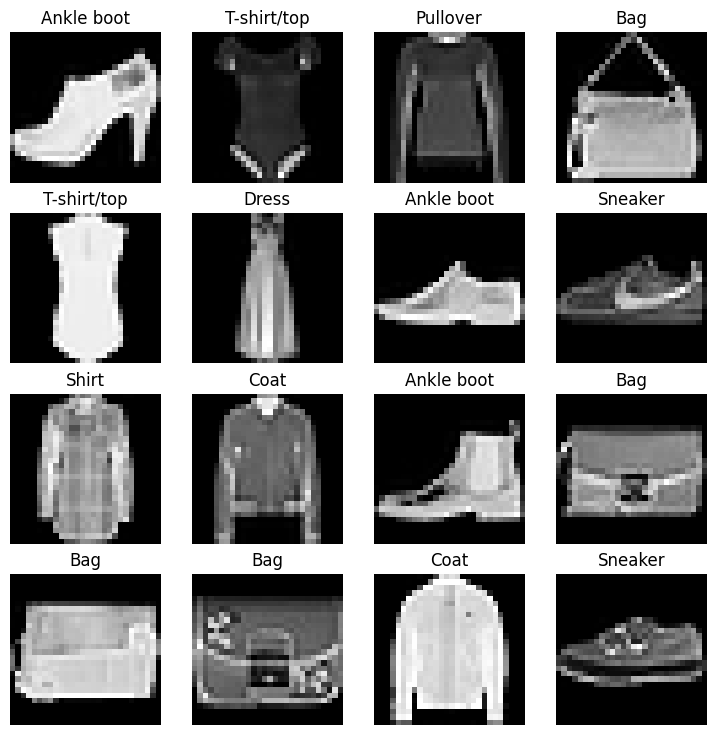

In [14]:
# Printing image
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

# Randomly selecting image
for i in range(1, rows * cols + 1):
    random_index = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_index]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap='grey')
    plt.title(class_names[label])
    plt.axis(False)

## Preparing DataLoader

Once the data is imported, its is in the form of PyTorch Datasets, to use it as an iterable, you must first transform it into a DataLoader. More specifically, we want or data to be in batches, in order to be able to store the images it's training on in memory. This has some advantages:

- More computationally efficient
- It gives the network more chances to update its weights per epoch. A model that doesn't use batches, only updates the weights once every epoch, whereas ones that use the leverage of batches update $N$ times, with this being the number of batches per dataset. In our case, we're using $32$ batches for both datasets, so $1875$ batches for the training data, and $313$ for the testing data ($312$ that fit entirely, and one with $16$ images).

To do this, we call the DataLoader class, pass our dataset as the `dataset` parameter, set the batch size with `batch_size`, and as an option, in cases where the data is originally ordered, we can set `shuffle=True`.


In [15]:
# Setting batch size
BATCH_SIZE = 32

# Creating training DataLoader
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True,
)

# Creating testing DataLoader
test_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True,
)

## Creating model

We're building a model with convolutional layers.


In [16]:
# Creating model with non-linear layers
class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 49,
                out_features=output_shape,
            ),
        )

    def forward(self, x: torch.Tensor) -> None:
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)

        return x

In [17]:
# Instantiating model
model = FashionMNISTModel(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names),
).to(device)

In [18]:
# Loss Function
import torch.optim.sgd


loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=0.1,
)

## Training model


In [19]:
# Setting seed
torch.manual_seed(42)

# Setting epochs
epochs = 3

# Main train loop
for epoch in tqdm(range(epochs)):
    print(
        f'Epoch: {epoch}',
        '-' * 90,
        sep='\n',
        end='\n',
    )

    # Train step
    train_step(
        estimator=model,
        dataloader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
    )

    # Test step
    test_step(
        estimator=model,
        loss_fn=loss_fn,
        dataloader=test_dataloader,
        device=device,
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------------------------------------------------------------------------------------------
Train loss: 0.545 | Train accuracy: 80.42%
Test loss:  0.356 | Test accuracy:  87.25%

Epoch: 1
------------------------------------------------------------------------------------------
Train loss: 0.352 | Train accuracy: 87.26%
Test loss:  0.341 | Test accuracy:  87.98%

Epoch: 2
------------------------------------------------------------------------------------------
Train loss: 0.317 | Train accuracy: 88.71%
Test loss:  0.294 | Test accuracy:  89.62%



In [20]:
# Evaluating model
model_results = eval_model(
    estimator=model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    device=device,
)

model_results

{'model_name': 'FashionMNISTModel', 'loss': 0.2935357987880707, 'acc': 89.625}

## Making predictions


In [21]:
# Creating samples and labels lists
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=len(test_data)):
    test_samples.append(sample)
    test_labels.append(label)

In [22]:
# Making predictions
pred_probs = make_predictions(estimator=model, data=test_samples, device=device)

pred_classes = pred_probs.argmax(dim=1)

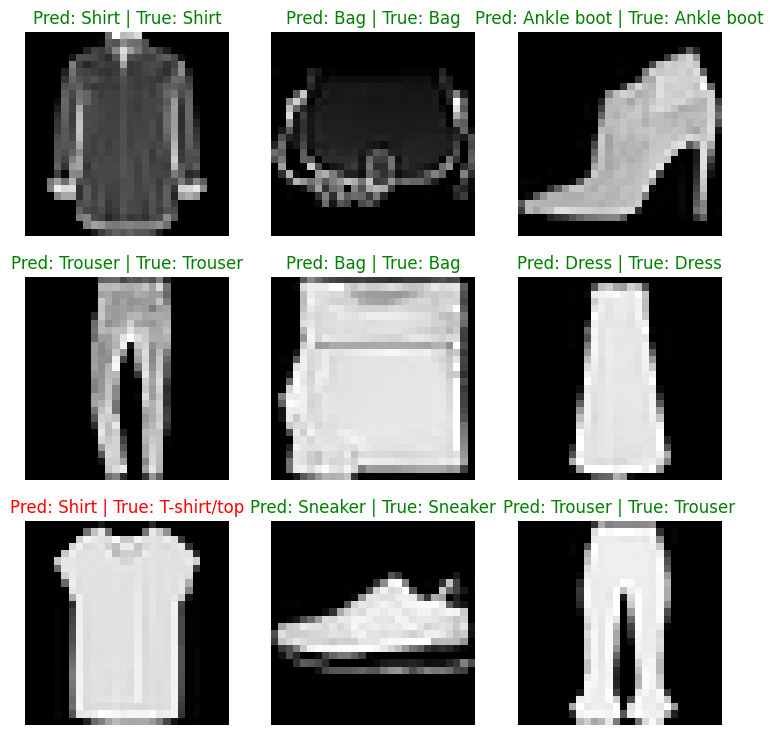

In [27]:
# Visualizing predictions
plt.figure(figsize=(9, 9))

nrows = 3
ncols = 3

random_index = random.randint(0, len(test_data) - 9)


for i, sample in enumerate(test_samples[random_index : random_index + 9]):
    plt.subplot(nrows, ncols, i + 1)

    plt.imshow(sample.squeeze(), cmap='grey')

    pred_label = class_names[pred_classes[i + random_index]]

    true_label = class_names[test_labels[i + random_index]]

    title_text = f'Pred: {pred_label} | True: {true_label}'

    plt.title(title_text, c='g' if pred_label == true_label else 'r')
    plt.axis(False)